# TP - Predicción del Período Orbital de Asteroides mediante Técnicas de Machine Learning

## Introducción

En nuestro proyecto, abordamos el desafío de predecir el período orbital de los asteroides en función de diversos atributos orbitales y físicos. El período orbital es el tiempo que un asteroide tarda en completar una vuelta alrededor del Sol. Comprender y predecir este período es crucial para la astronomía, ya que nos ayuda a seguir la trayectoria de estos cuerpos celestes y a evaluar posibles riesgos de impacto con la Tierra.

Para realizar esta predicción, contamos con un conjunto de datos que incluye una variedad de características como el semieje mayor, la excentricidad, la inclinación, la magnitud absoluta, entre otros. Nuestro objetivo es identificar cuáles de estos atributos tienen un valor predictivo significativo y utilizarlos para construir un modelo de machine learning robusto y preciso.

Este proyecto nos permitirá aplicar nuestras habilidades en ciencia de datos, desde la exploración y preprocesamiento de datos hasta la implementación de modelos predictivos, y contribuirá a nuestro entendimiento sobre la dinámica de los asteroides. En esta etapa intermedia de nuestro proyecto, presentaremos nuestros hallazgos preliminares y los pasos que hemos seguido hasta ahora en la construcción de nuestro modelo predictivo.

## Análisis Exploratorio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Librerías necesarias

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


import seaborn as sns
import matplotlib.pyplot as plt

## Fuente:
Todos los datos provienen de (http://neo.jpl.nasa.gov/). Esta API es mantenida por el equipo de SpaceRocks: David Greenfield, Arezu Sarvestani, Jason English y Peter Baunach.


### Paths

In [ ]:
path_ale = '/content/drive/MyDrive/Colab Notebooks/Asteroid_Updated.csv'
path_nico = 'G:\Mi unidad\Licenciatura en Ciencia de Datos\Introduccion al Aprendizaje Automatico\Guias\Tp final - IAA\data\Asteroid_Updated.csv'


In [ ]:
#Asteroide_df = pd.read_csv(path_ale)
Asteroide_df = pd.read_csv(path_nico)

Asteroide_df.columns

C:\Users\nicol\AppData\Local\Temp\ipykernel_6320\2467647605.py:2: DtypeWarning: Columns (0,10,15,16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  Asteroide_df = pd.read_csv(path_nico)


Index(['name', 'a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'neo', 'pha', 'diameter', 'extent',
       'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G',
       'moid', 'class', 'n', 'per', 'ma'],
      dtype='object')

Tomaremos como target a la variable ***per*** por lo tanto eliminaremos el feature **per_y** ya que por definicion es el mismo atributo en distintas variaciones temporales. A la hora de querer predecir el periodo orbital en dias estariamos usando dos veces la misma informacion y seria un leak.

In [ ]:
Asteroide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839714 entries, 0 to 839713
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            21967 non-null   object 
 1   a               839712 non-null  float64
 2   e               839714 non-null  float64
 3   i               839714 non-null  float64
 4   om              839714 non-null  float64
 5   w               839714 non-null  float64
 6   q               839714 non-null  float64
 7   ad              839708 non-null  float64
 8   per_y           839713 non-null  float64
 9   data_arc        824240 non-null  float64
 10  condition_code  838847 non-null  object 
 11  n_obs_used      839714 non-null  int64  
 12  H               837025 non-null  float64
 13  neo             839708 non-null  object 
 14  pha             823272 non-null  object 
 15  diameter        137636 non-null  object 
 16  extent          18 non-null      object 
 17  albedo    

In [ ]:
Asteroide_df = Asteroide_df.drop("per_y", axis=1)

Se eleminan los siguientes atributos del dataset ya que tomamos como hipotesis que no informan ninguna relación con el periodo orbital.

In [ ]:
Asteroide_df = Asteroide_df.drop(["name", "condition_code", "n_obs_used", "data_arc",
                                  "spec_B", "spec_T", "rot_per", "GM", "BV", "UB", "G", "albedo", "neo", "pha","extent", "IR"], axis=1)

'''
    'name': 'nombre',  # Nombre del asteroide
    'data_arc': 'arco_de_datos',  # Arco de datos disponible (en días)
    'condition_code': 'codigo_de_condicion',  # Código de condición
    'n_obs_used': 'num_observaciones_utilizadas',  # Número de observaciones utilizadas
    'neo': 'objeto_cercano_a_Tierra',  # Indicador de objeto cercano a la Tierra (N = sí, Y = no)
    'pha': 'asteroide_peligroso',  # Indicador de asteroide potencialmente peligroso (N = no, Y = sí)
    'extent': 'extension',  # Extensión
    'albedo': 'albedo',  # Albedo del asteroide
    'rot_per': 'periodo_de_rotacion',  # Período de rotación del asteroide (en horas)
    'GM': 'masa_estandar',  # Masa estándar
    'BV': 'BV',  # BV
    'UB': 'UB',  # UB
    'IR': 'IR',  # IR
    'spec_B': 'espectro_B',  # Espectro B
    'spec_T': 'espectro_T',  # Espectro T
    'G': 'G',  # G
    'class': 'clase',  # Clase del asteroide
'''

"\n    'name': 'nombre',  # Nombre del asteroide\n    'data_arc': 'arco_de_datos',  # Arco de datos disponible (en días)\n    'condition_code': 'codigo_de_condicion',  # Código de condición\n    'n_obs_used': 'num_observaciones_utilizadas',  # Número de observaciones utilizadas\n    'neo': 'objeto_cercano_a_Tierra',  # Indicador de objeto cercano a la Tierra (N = sí, Y = no)\n    'pha': 'asteroide_peligroso',  # Indicador de asteroide potencialmente peligroso (N = no, Y = sí)\n    'extent': 'extension',  # Extensión\n    'albedo': 'albedo',  # Albedo del asteroide\n    'rot_per': 'periodo_de_rotacion',  # Período de rotación del asteroide (en horas)\n    'GM': 'masa_estandar',  # Masa estándar\n    'BV': 'BV',  # BV\n    'UB': 'UB',  # UB\n    'IR': 'IR',  # IR\n    'spec_B': 'espectro_B',  # Espectro B\n    'spec_T': 'espectro_T',  # Espectro T\n    'G': 'G',  # G\n    'class': 'clase',  # Clase del asteroide\n"

Notamos que el atributo class es un leak ya que por definicion cada clase de asteroide es clasificado por su periodo orbital.

In [ ]:
Asteroide_df = Asteroide_df.drop(["class"], axis=1)

In [ ]:
# Clases de asteroides 'MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE','AST', 'TNO', 'IEO', 'HYA', 'PAA'
#https://pdssbn.astro.umd.edu/data_other/objclass.shtml

### Definiciones en español

In [ ]:
Asteroide_df_español = {
    'a': 'semieje_mayor', # Medido en unidades astronómicas (ua), es la distancia promedio desde el foco de la elipse hasta el centro de la elipse.
    'e': 'excentricidad', # Describe la forma de la órbita elíptica del asteroide. Es un número entre 0 y 1, donde 0 representa una órbita circular perfecta y 1 una órbita altamente elíptica.
    'i': 'inclinacion', # El ángulo entre el plano orbital del asteroide y el plano de la eclíptica (el plano formado por la órbita de la Tierra alrededor del Sol), medido en grados.
    'om': 'longitud_nodo_ascendente', # El ángulo medido desde un punto de referencia hacia el punto en la órbita donde el asteroide cruza de sur a norte a través del plano orbital de la Tierra, medido en grados.
    'w': 'argumento_perihelio', # El ángulo medido desde el nodo ascendente hasta el punto más cercano al Sol (perihelio) en la órbita del asteroide, medido en grados.
    'q': 'distancia_perihelio', # La distancia más cercana al Sol a lo largo de la órbita del asteroide, medida en unidades astronómicas (ua).
    'ad': 'distancia_afelio', # La distancia más lejana al Sol a lo largo de la órbita del asteroide, medida en unidades astronómicas (ua).
    'per_y': 'periodo_orbital_anios', # El tiempo que tarda un asteroide en dar una vuelta completa alrededor del Sol, medido en años.
    'H': 'magnitud_absoluta', # Una medida de brillo aparente de un asteroide si estuviera a una distancia estándar de 1 ua del Sol y de la Tierra.
    'diameter': 'diametro',  # Diámetro del asteroide (en kilómetros)
    'moid': 'distancia_interseccion_orbital_Tierra', # La distancia más cercana entre la órbita del asteroide y la órbita de la Tierra, medida en unidades astronómicas (ua).
    'n': 'movimiento_medio', # La velocidad angular promedio del asteroide en su órbita alrededor del Sol, medida en grados por día.
    'per': 'periodo_orbital_dias', # Similar al período orbital en años, pero medido en días.
    'ma': 'anomalia_media' # El ángulo que describe la posición del asteroide a lo largo de su órbita en relación con un punto de referencia en el perihelio, medido en grados.
}

In [ ]:
Asteroide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839714 entries, 0 to 839713
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   a         839712 non-null  float64
 1   e         839714 non-null  float64
 2   i         839714 non-null  float64
 3   om        839714 non-null  float64
 4   w         839714 non-null  float64
 5   q         839714 non-null  float64
 6   ad        839708 non-null  float64
 7   H         837025 non-null  float64
 8   diameter  137636 non-null  object 
 9   moid      823272 non-null  float64
 10  n         839712 non-null  float64
 11  per       839708 non-null  float64
 12  ma        839706 non-null  float64
dtypes: float64(12), object(1)
memory usage: 83.3+ MB


In [ ]:
Asteroide_df['diameter'].head()

0      939.4
1        545
2    246.596
3      525.4
4    106.699
Name: diameter, dtype: object

Observamos que el feature de diameter es de tipo objeto porque tiene entradas como string o como float. Decidimos convertirlo en float

In [ ]:
Asteroide_df['diameter'] = pd.to_numeric(Asteroide_df['diameter'], errors='coerce')

**Existen 8 columnas que cuentan con datos faltantes (NA)**



In [ ]:
Asteroide_df.isna().sum()

a                2
e                0
i                0
om               0
w                0
q                0
ad               6
H             2689
diameter    702079
moid         16442
n                2
per              6
ma               8
dtype: int64

In [ ]:
# Visualizar las primeras filas del dataframe
print(Asteroide_df.head())

# Información general del dataframe
print(Asteroide_df.info())

# Estadísticas descriptivas
print(Asteroide_df.describe())


          a         e          i          om           w         q        ad  \
0  2.769165  0.076009  10.594067   80.305532   73.597694  2.558684  2.979647   
1  2.772466  0.230337  34.836234  173.080063  310.048857  2.133865  3.411067   
2  2.669150  0.256942  12.988919  169.852760  248.138626  1.983332  3.354967   
3  2.361418  0.088721   7.141771  103.810804  150.728541  2.151909  2.570926   
4  2.574249  0.191095   5.366988  141.576605  358.687607  2.082324  3.066174   

      H  diameter     moid         n          per          ma  
0  3.34   939.400  1.59478  0.213885  1683.145708   77.372096  
1  4.13   545.000  1.23324  0.213503  1686.155999   59.699133  
2  5.33   246.596  1.03454  0.226019  1592.787285   34.925016  
3  3.20   525.400  1.13948  0.271609  1325.432765   95.861936  
4  6.85   106.699  1.09589  0.238632  1508.600458  282.366289  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839714 entries, 0 to 839713
Data columns (total 13 columns):
 #   Column    Non-Null 

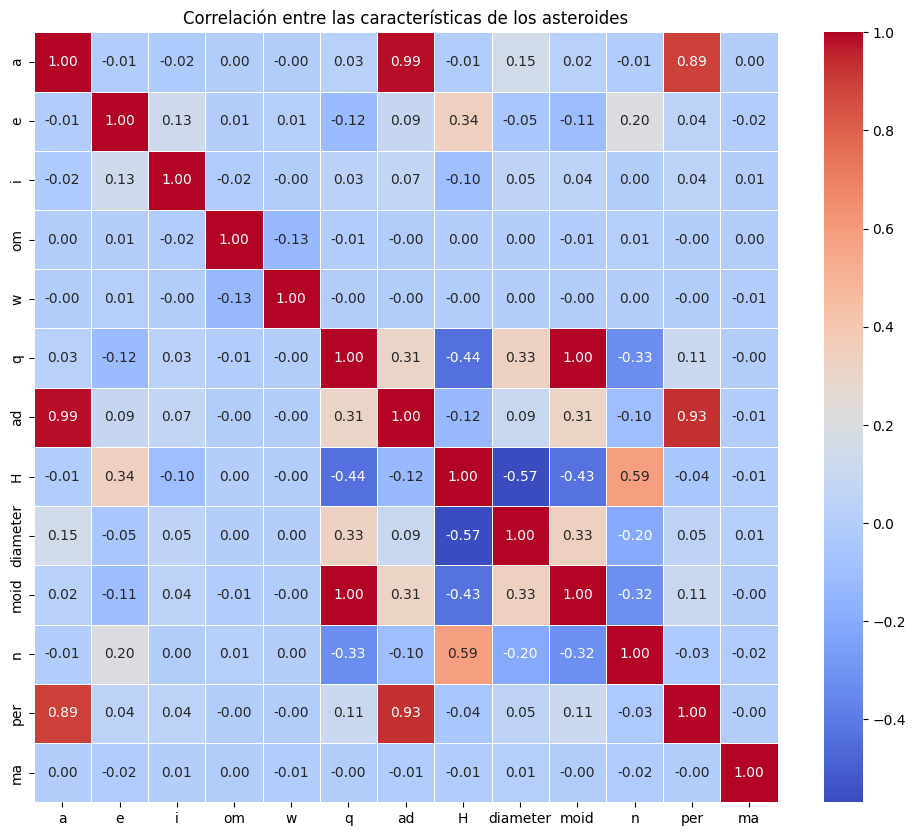

In [ ]:
# Mapa de correlación
corr = Asteroide_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación entre las características de los asteroides')
plt.show()


Dado que el semieje mayor (a) y la distancia al afelio (ad) están relacionados con la distancia del asteroide al Sol en diferentes puntos de su órbita elíptica, es de esperar que estén altamente correlacionados.

Vemos una alta correlación de nuestro target con el feature a y el feature ad, comprobaremos si son los targets mas influyentes.

Distribuciones por atributo

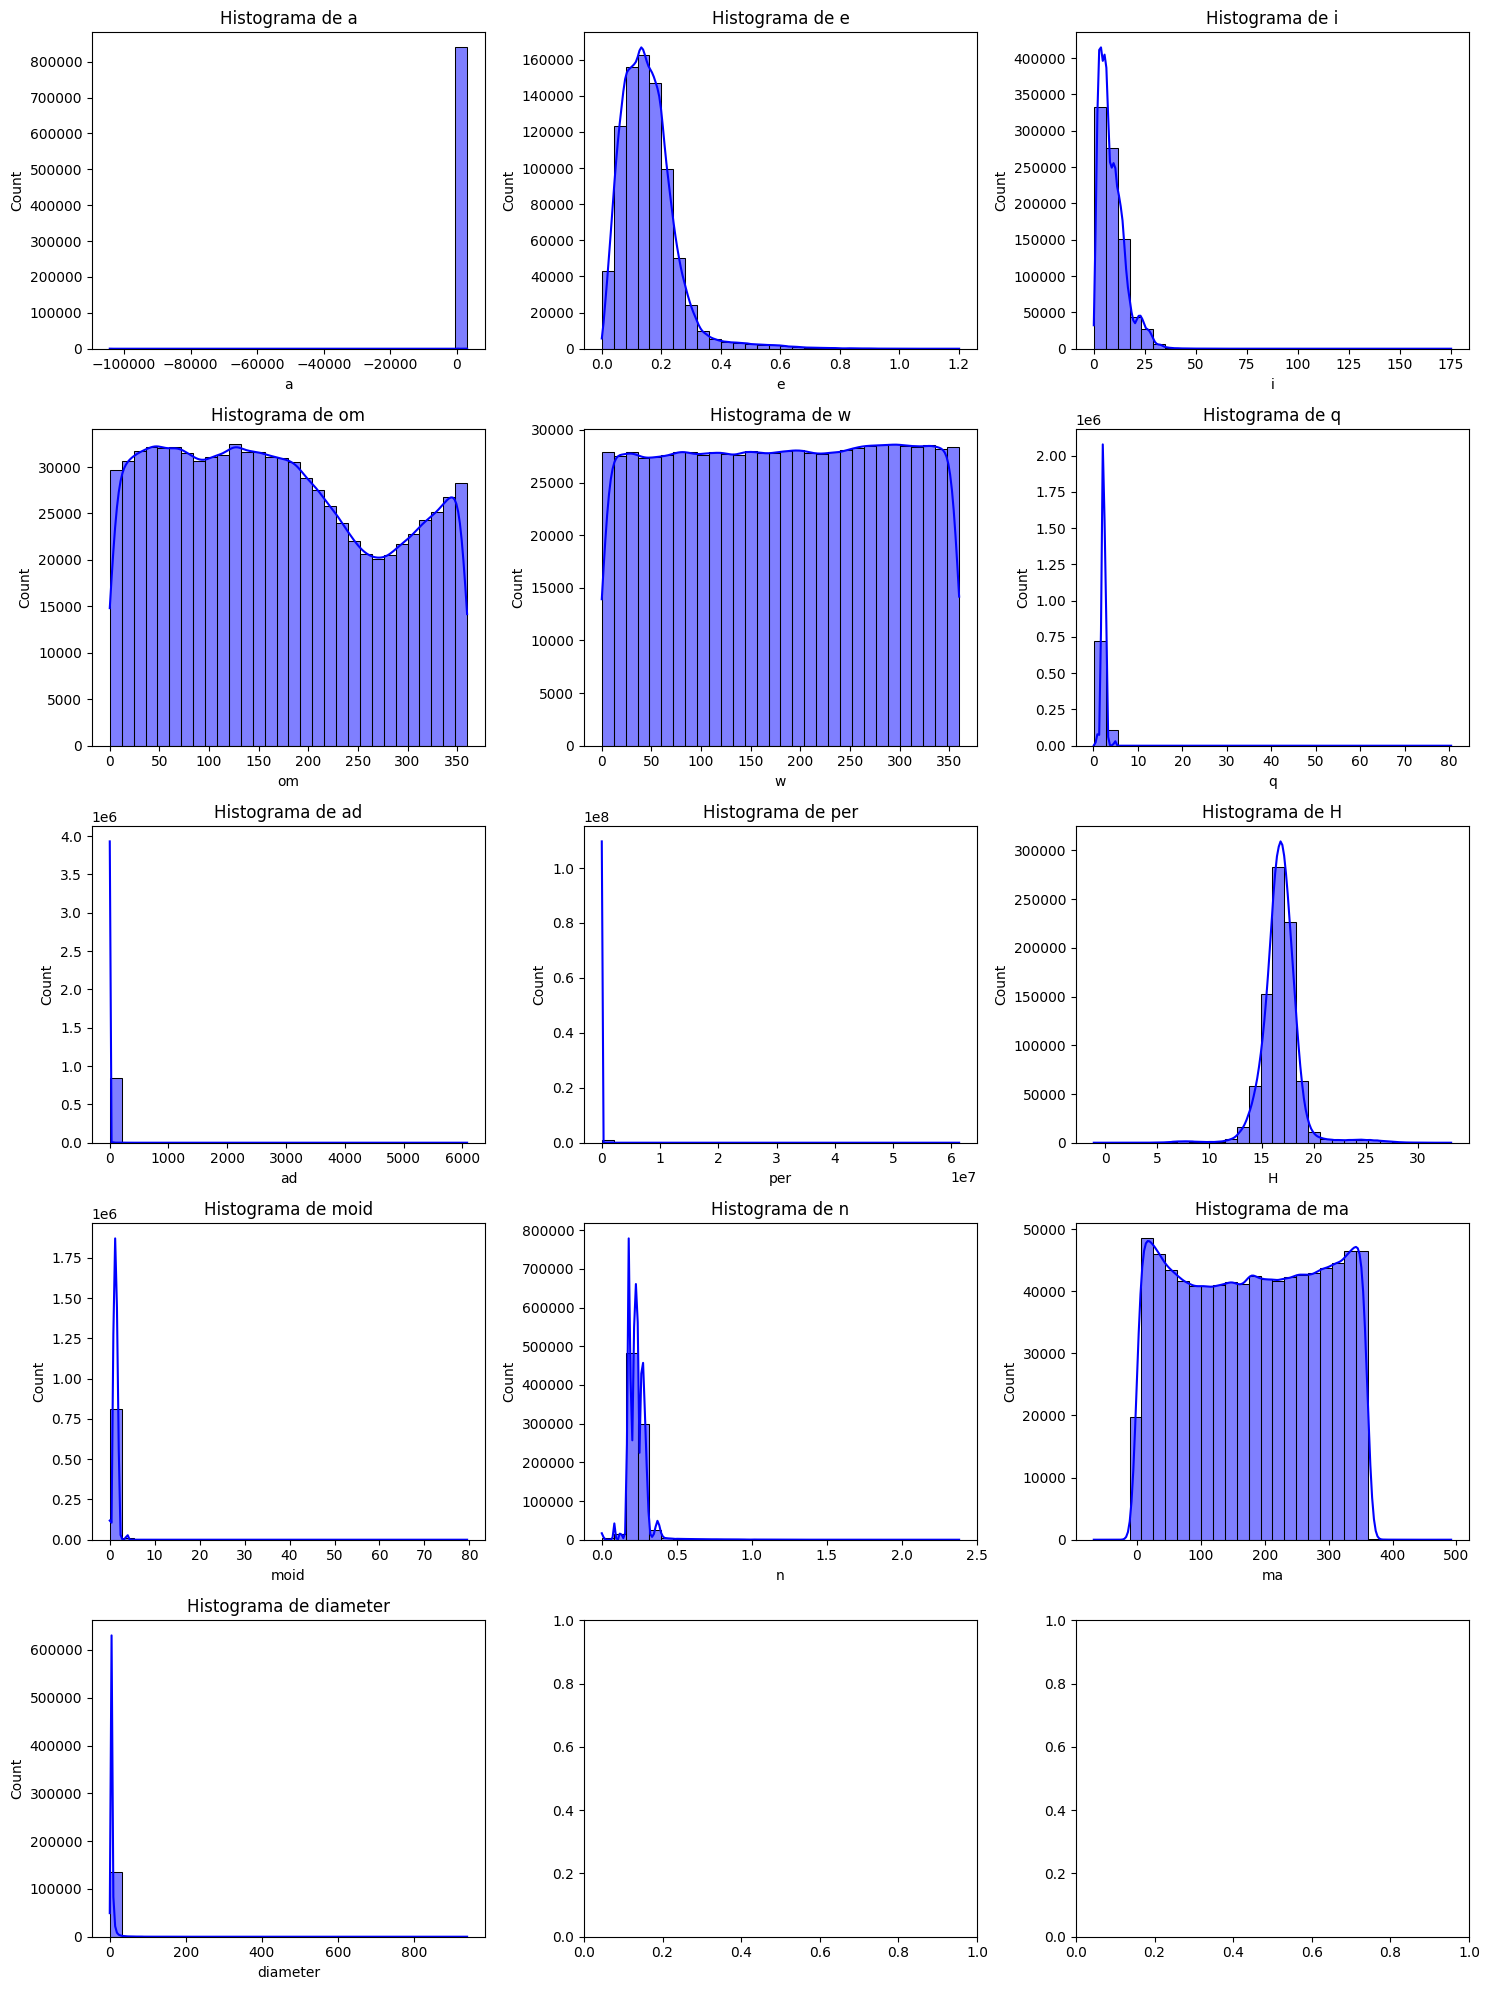

In [ ]:
# Crear una cuadrícula de subgráficos de 5x3 (suficiente para 15 gráficos)
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

# Variables a trazar
variables = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per', 'H', 'moid', 'n', 'ma', 'diameter']

# Iterar sobre las variables y trazar un histograma para cada una
for i, var in enumerate(variables):
    row = i // 3  # Fila del subgráfico
    col = i % 3   # Columna del subgráfico
    sns.histplot(data=Asteroide_df, x=var, bins=30, color='blue', kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Histograma de {var}')

# Ajustar la disposición de los subgráficos
plt.tight_layout()
plt.show()



Podemos observar que los datos no estan estandarizados y cuentan con outliers. Haremos la preparación de los datos

<class 'pandas.core.frame.DataFrame'>
Index: 120435 entries, 227 to 810375
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   a         120435 non-null  float64
 1   e         120435 non-null  float64
 2   i         120435 non-null  float64
 3   om        120435 non-null  float64
 4   w         120435 non-null  float64
 5   q         120435 non-null  float64
 6   ad        120435 non-null  float64
 7   H         120435 non-null  float64
 8   diameter  120435 non-null  float64
 9   moid      120435 non-null  float64
 10  n         120435 non-null  float64
 11  per       120435 non-null  float64
 12  ma        120435 non-null  float64
dtypes: float64(13)
memory usage: 12.9 MB
None


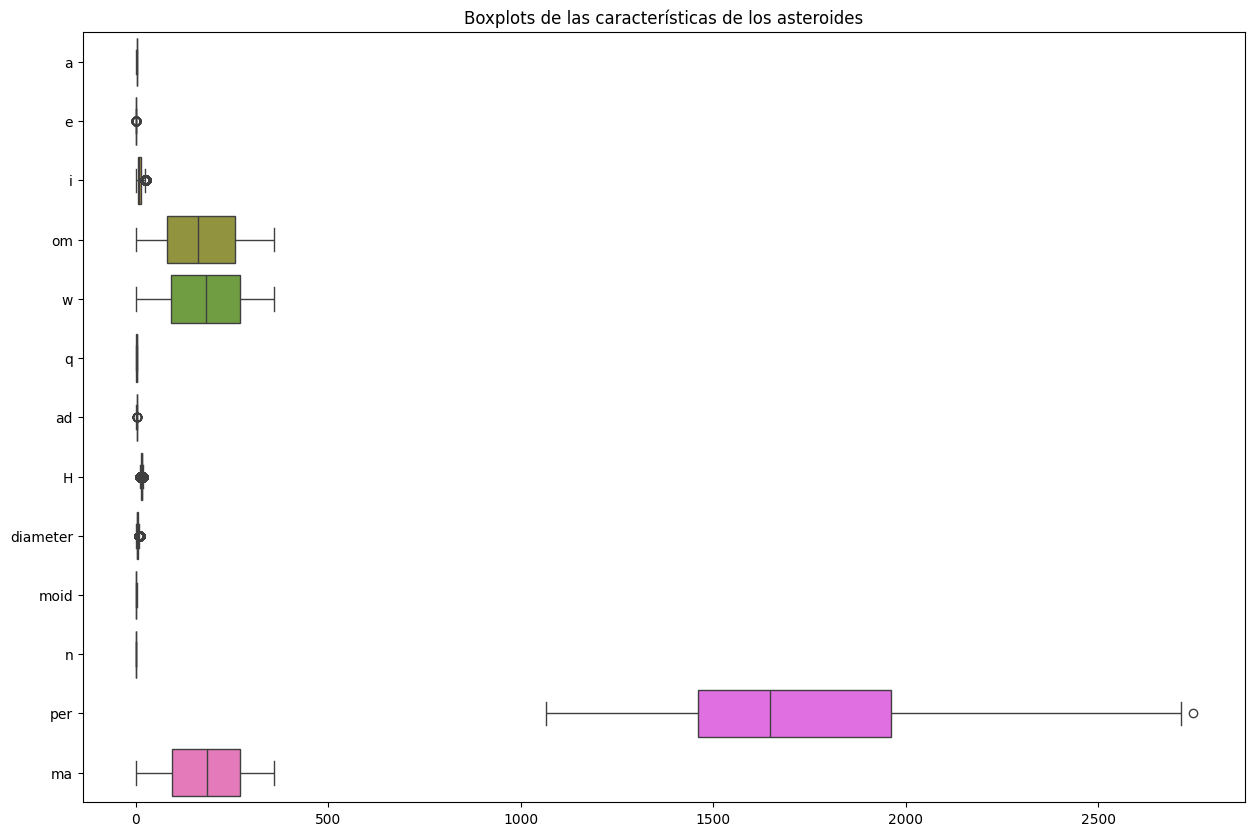

In [ ]:
# Imputación o eliminación de valores faltantes
Asteroide_df = Asteroide_df.dropna()

# Identificar el rango intercuartílico (IQR) para cada columna
Q1 = Asteroide_df.quantile(0.25)
Q3 = Asteroide_df.quantile(0.75)
IQR = Q3 - Q1
Bigote_inferior = Q1 - 1.5 * IQR
Bigote_superior = Q3 + 1.5 * IQR

# Filtrar los outliers
Asteroide_df = Asteroide_df[~((Asteroide_df < Bigote_inferior) | (Asteroide_df > Bigote_superior)).any(axis=1)]

# Información del dataframe después de eliminar outliers
print(Asteroide_df.info())

# Boxplots de las características seleccionadas
plt.figure(figsize=(15, 10))
sns.boxplot(data=Asteroide_df[['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'H', 'diameter', 'moid', 'n', 'per', 'ma']], orient='h')
plt.title('Boxplots de las características de los asteroides')
plt.show()

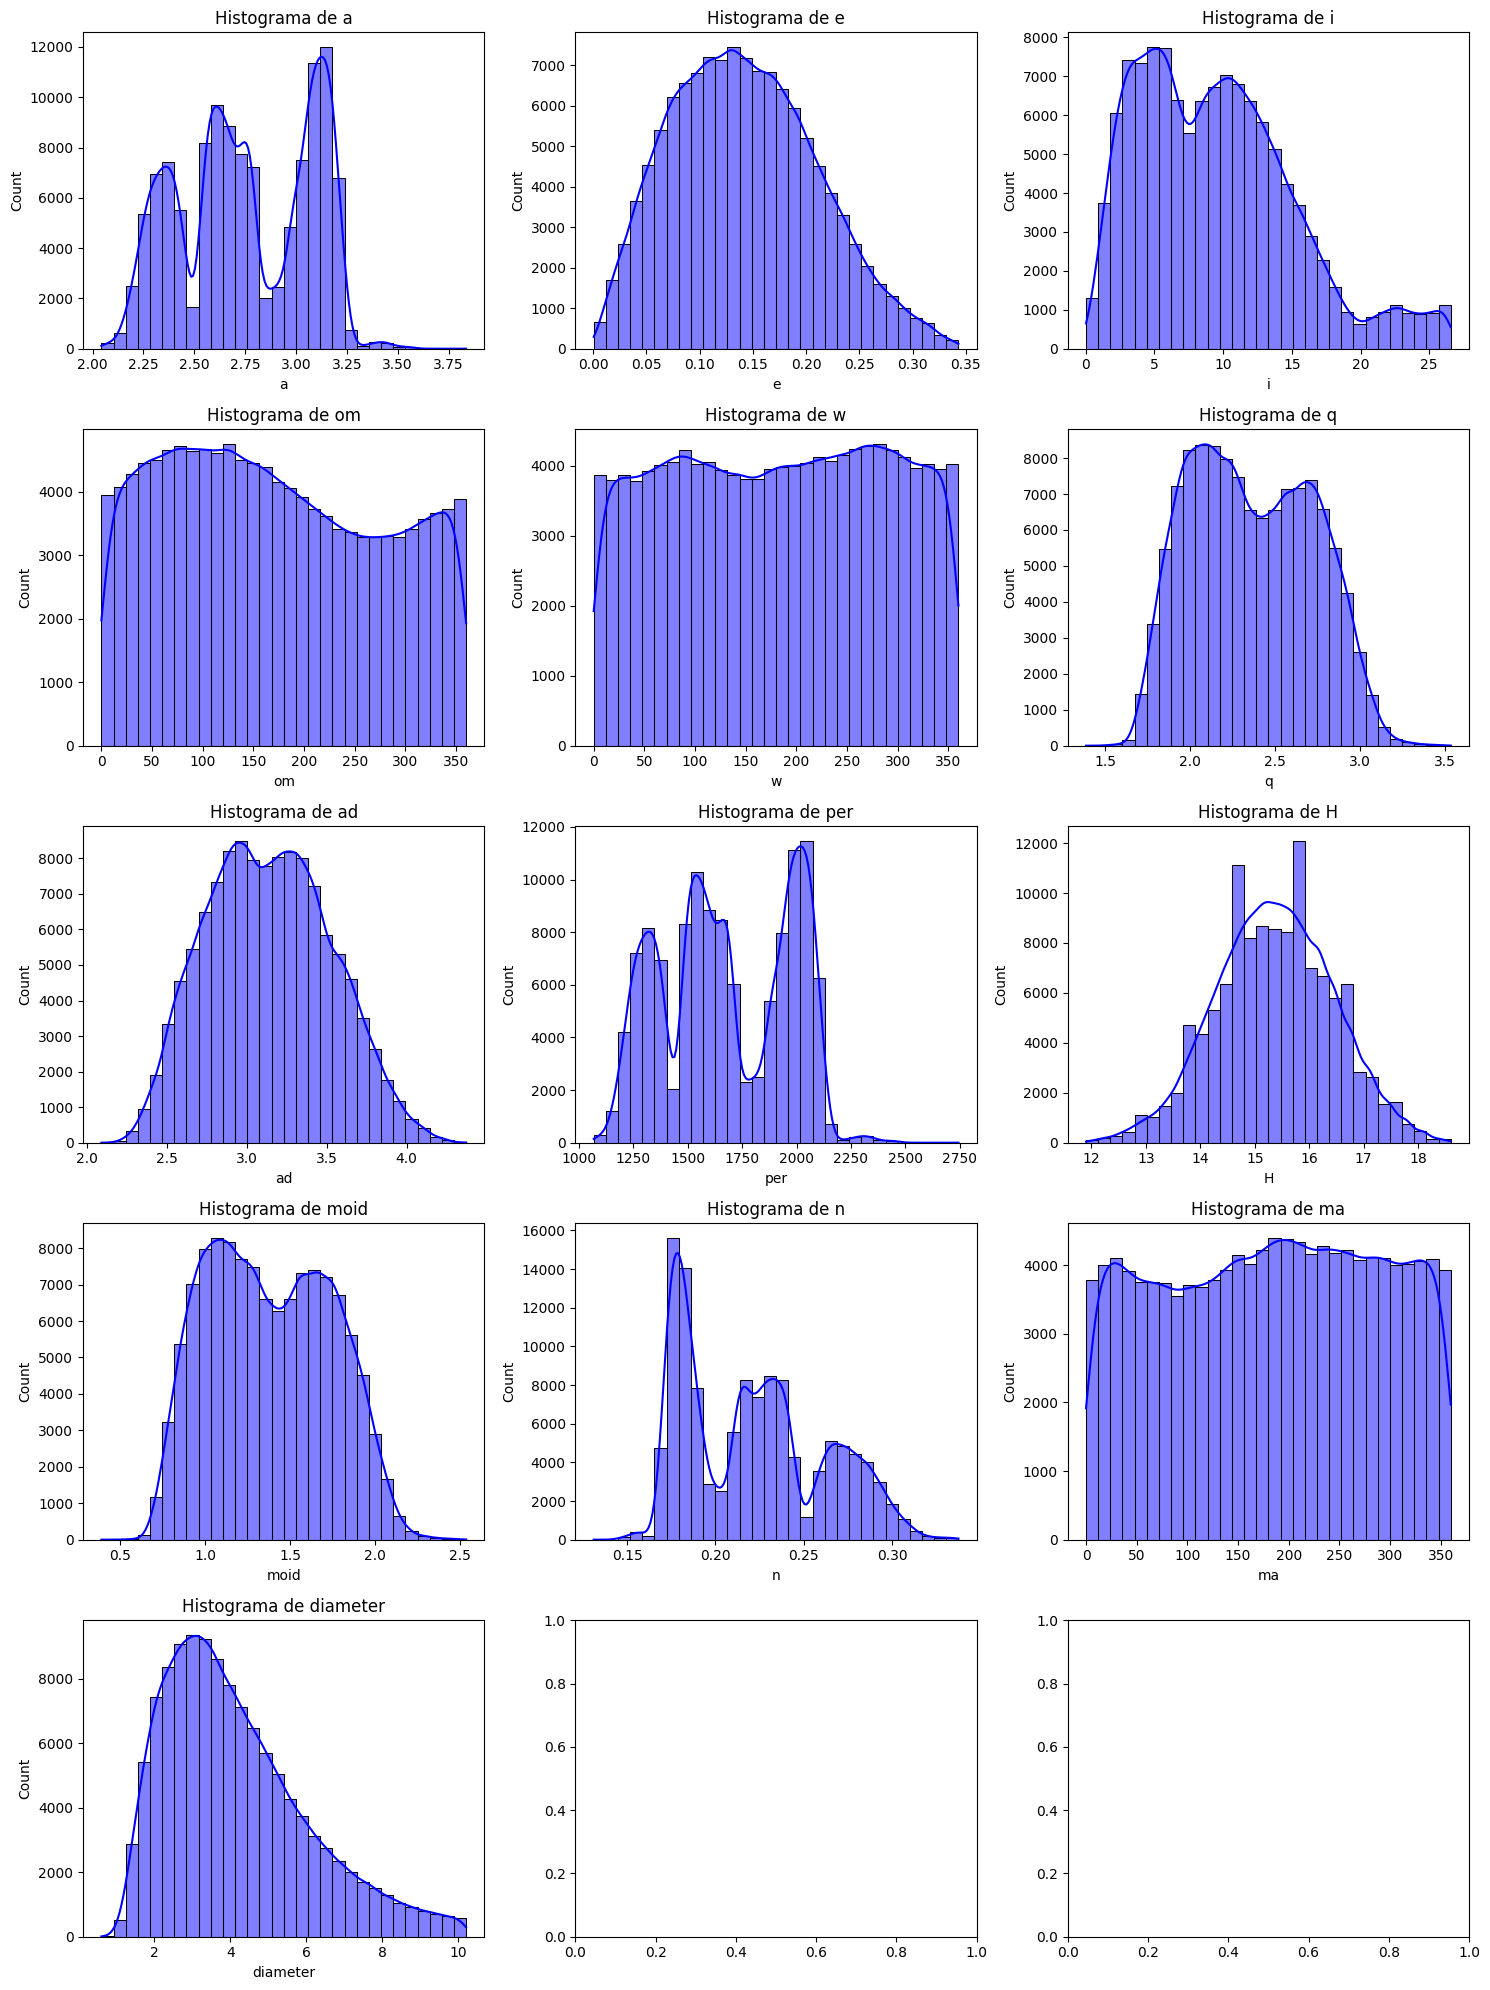

In [ ]:
# Crear una cuadrícula de subgráficos de 5x3 (suficiente para 15 gráficos)
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

# Variables a trazar
variables = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per', 'H', 'moid', 'n', 'ma', 'diameter']

# Iterar sobre las variables y trazar un histograma para cada una
for i, var in enumerate(variables):
    row = i // 3  # Fila del subgráfico
    col = i % 3   # Columna del subgráfico
    sns.histplot(data=Asteroide_df, x=var, bins=30, color='blue', kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Histograma de {var}')

# Ajustar la disposición de los subgráficos
plt.tight_layout()
plt.show()


### Comenzaremos con los modelos

In [ ]:
Asteroide_df.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'H', 'diameter', 'moid', 'n',
       'per', 'ma'],
      dtype='object')

MSE: 21.05905605894505


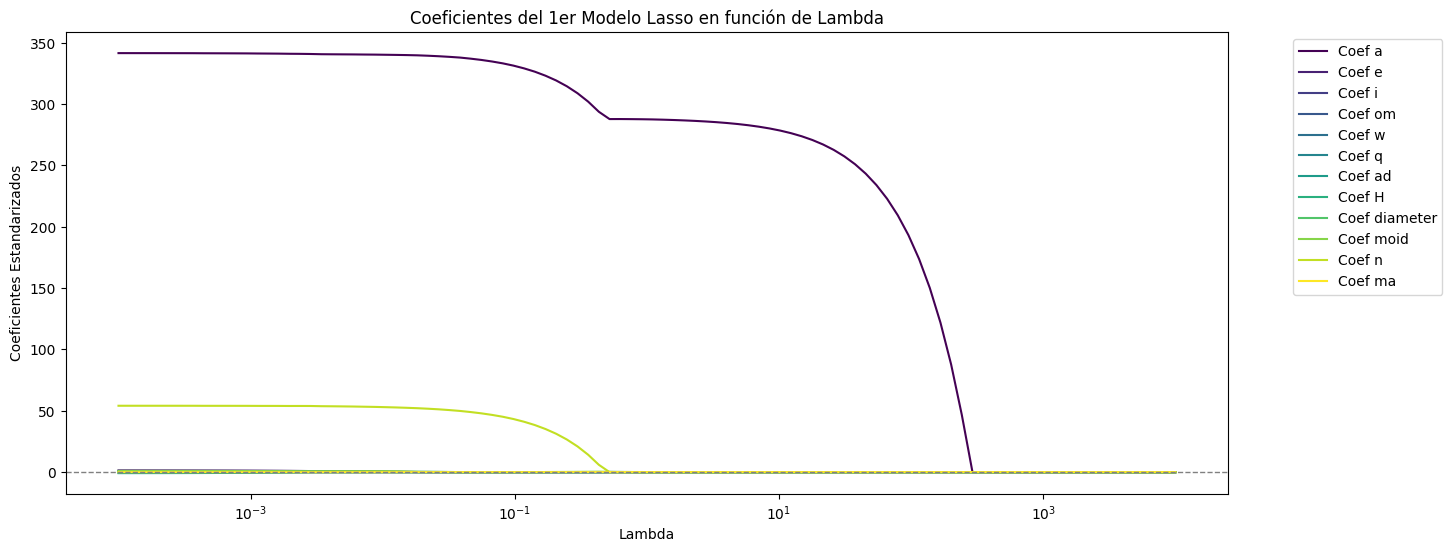

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

# Selección de características
features = Asteroide_df.drop(columns=['per'])
target = 'per'

# División de datos
X = features
y = Asteroide_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mse_values = []
df_residuos = pd.DataFrame()
df_residuos['per_real'] = y_test.copy()


# Crear un pipeline para LassoCV
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000))
])

lasso_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = lasso_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

df_residuos['residuo'] = y_test.copy() - y_pred.copy()

# Obtener los coeficientes y alphas de LassoCV
coefficients = lasso_pipeline.named_steps['lasso'].coef_
alphas = lasso_pipeline.named_steps['lasso'].alphas_

# Valores de lambda para Lasso
lambdas = np.logspace(-4, 4, 100)
all_coefficients = []

# Usar los mismos datos escalados para el modelo Lasso
scaler = lasso_pipeline.named_steps['scaler']
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



for l in lambdas:
    lasso = Lasso(alpha=l, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    all_coefficients.append(lasso.coef_)

all_coefficients = np.array(all_coefficients)

# Gráfico de lambda en función de los coeficientes
plt.figure(figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, all_coefficients.shape[1]))
for i in range(all_coefficients.shape[1]):
    plt.plot(lambdas, all_coefficients[:, i], label=f'Coef {features.columns[i]}', color=colors[i])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coeficientes Estandarizados')
plt.title('Coeficientes del 1er Modelo Lasso en función de Lambda')
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

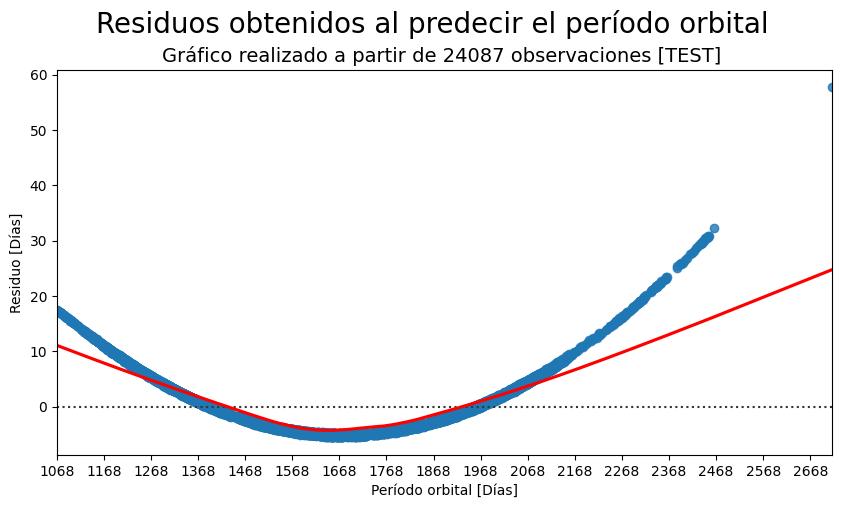

In [ ]:
from math import floor, ceil
min_x = floor(min(y_test))
max_x = ceil(max(y_test))
ticks = range(min_x, max_x + 1,100)

# Crear un gráfico de residuos con línea de suavizado local
plt.figure(figsize=(10,5 ), dpi=100)
sns.residplot(x="per_real", y="residuo", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

Segundo modelo

Grado: 1, Mean Squared Error: 21.059056058946442
Grado: 2, Mean Squared Error: 0.18197008618362143
Grado: 3, Mean Squared Error: 0.3574131432804117


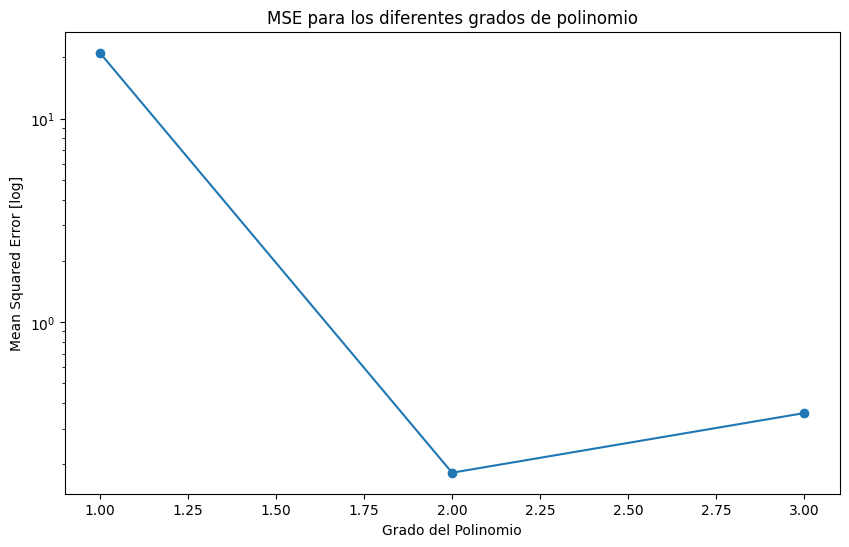

In [ ]:
from sklearn.linear_model import LassoCV

# Selección de características
features = Asteroide_df.drop(columns=['per'])
target = 'per'

# División de datos
X = features
y = Asteroide_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear polinomios específicos y LassoCV para cada modelo
degrees = [1, 2 ,3]
mse_values = []
df_residuos = pd.DataFrame()
df_residuos['per_real'] = y_test.copy()

for degree in degrees:

    poly = PolynomialFeatures(degree=int(degree), include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Escalado de características
    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_test_poly = scaler.transform(X_test_poly)

    # Entrenar el modelo LassoCV
    lasso = LassoCV(cv=5,max_iter=1000000, random_state=42)
    lasso.fit(X_train_poly, y_train)

    # Predicción y evaluación
    y_pred = lasso.predict(X_test_poly)
    df_residuos['residuos_grado_'+ str(degree)] = y_test.copy() - y_pred.copy()
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

    print(f'Grado: {degree}, Mean Squared Error: {mse}')

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values, marker='o')
plt.xlabel('Grado del Polinomio')
plt.ylabel('Mean Squared Error [log]')
plt.yscale('log')
plt.title('MSE para los diferentes grados de polinomio')
plt.show()





In [ ]:
print(df_residuos)

           per_real  residuos_grado_1  residuos_grado_2  residuos_grado_3
359492  1794.280056         -4.130805         -0.008657          0.105321
46510   1884.913244         -2.246660          0.211066          0.205536
115673  1595.086386         -4.896390         -0.430869         -0.603069
202371  1970.896758          0.662669          0.414206          0.639537
158092  1644.140579         -5.278913         -0.353607         -0.437991
...             ...               ...               ...               ...
148736  1660.045971         -5.203646         -0.310224         -0.349813
627769  1502.649467         -3.542669         -0.518563         -0.706938
106722  1963.111767          0.286702          0.394830          0.480185
388900  1417.050506         -1.445175         -0.491378         -0.854488
101228  1327.874626          2.116312         -0.282652         -0.036344

[24087 rows x 4 columns]


# Análisis de los residuos del modelo polinomico

Otra forma de comprobar que el modelo elegido brinda una buena explicación del problema de estudio es a través del análisis de los residuos.
Ya que nos permite ver si el tipo de relación entre la variable objetivo y las variables predictorias es la adecuada. A su vez que se puede ver si los residuos se distribuyen al azar alrededor del '' 0 '' o si lo hacen siguiendo siguiendo un patrón.


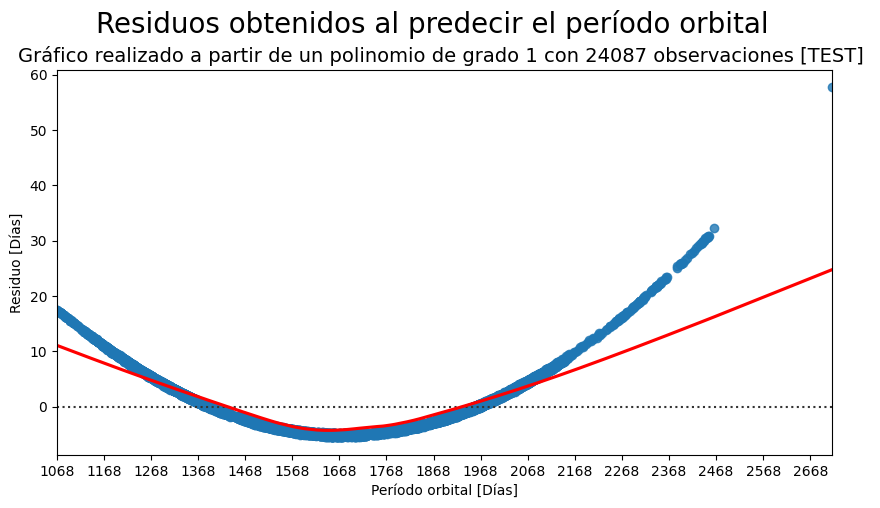

In [ ]:
# Crear un gráfico de residuos con línea de suavizado local
plt.figure(figsize=(10,5 ), dpi=100)
sns.residplot(x="per_real", y="residuos_grado_1", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de un polinomio de grado 1 con {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

En este caso, los residuos se distribuyen formando una parábola lo que dice que para explicar los datos se necesita utilizar un polimonio de grado mayor.

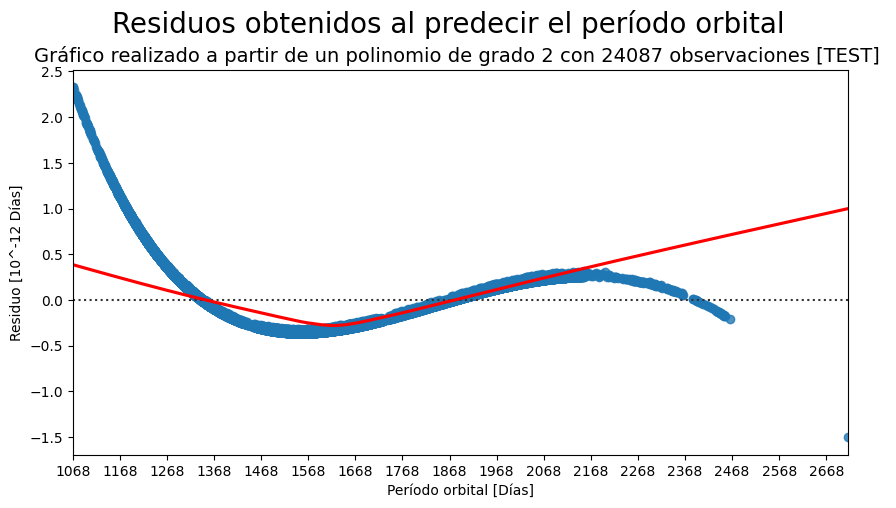

In [ ]:
plt.figure(figsize=(10,5 ), dpi=100)
plt.plot(alpha = 0.2)
# Crear un gráfico de residuos con línea de suavizado local
sns.residplot(x="per_real", y="residuos_grado_2", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de un polinomio de grado 2 con {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

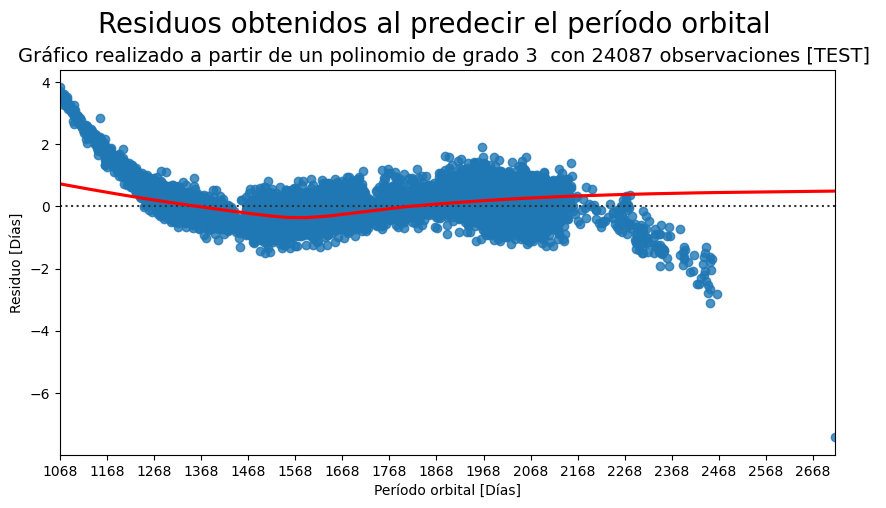

In [ ]:
plt.figure(figsize=(10,5 ), dpi=100)
plt.plot(alpha = 0.2)
# Crear un gráfico de residuos con línea de suavizado local
sns.residplot(x="per_real", y="residuos_grado_3", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de un polinomio de grado 3  con {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

Podemos observar que los residuos siguen siendo sesgados

Probamos ajustando a grados fraccionarios y enteros

Grado: 1, Mean Squared Error: 21.059056058946442
Grado: 1.5, Mean Squared Error: 0.9890734919153321
Grado: 2, Mean Squared Error: 0.18197008618362143
Grado: 2.5, Mean Squared Error: 0.23158647228512041
Grado: 3, Mean Squared Error: 0.3574131432804117


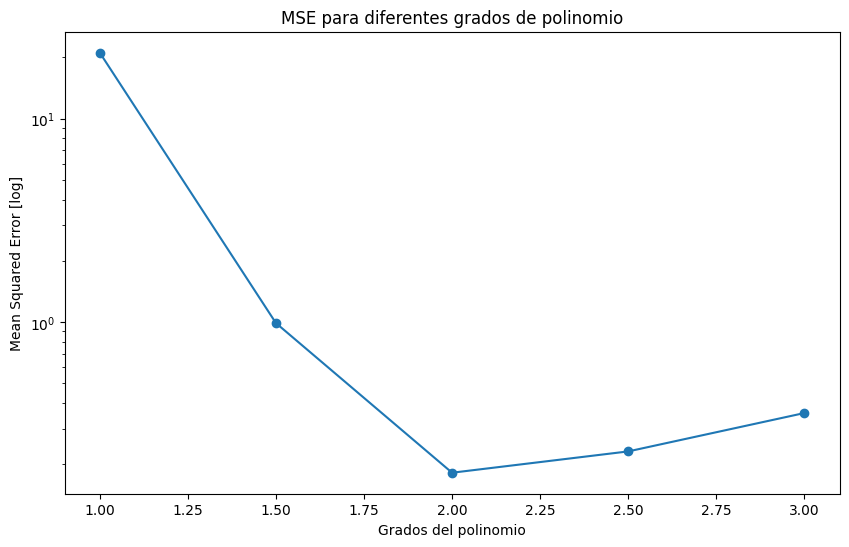

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

# Selección de características
features = Asteroide_df.drop(columns=['per'])
target = 'per'

# División de datos
X = features
y = Asteroide_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear polinomios específicos y LassoCV para cada modelo
degrees = [1, 1.5, 2, 2.5, 3]
mse_values = []
df_residuos = pd.DataFrame()
df_residuos['per_real'] = y_test.copy()

for degree in degrees:
    # Crear nuevas características polinomiales
    if degree == 1.5 or degree == 2.5:
        X_train_poly = np.concatenate([X_train, np.power(X_train, degree)], np.power(X_train, degree), axis=1)
        X_test_poly = np.concatenate([X_test, np.power(X_test, degree)], axis=1)
    else:
        poly = PolynomialFeatures(degree=int(degree), include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

    # Escalado de características
    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_test_poly = scaler.transform(X_test_poly)

    # Entrenar el modelo LassoCV
    lasso = LassoCV(cv=5,max_iter=1000000, random_state=42)
    lasso.fit(X_train_poly, y_train)

    # Predicción y evaluación
    y_pred = lasso.predict(X_test_poly)
    df_residuos['residuos_grado_'+ str(degree)] = y_test.copy() - y_pred.copy()
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

    print(f'Grado: {degree}, Mean Squared Error: {mse}')

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values, marker='o')
plt.xlabel('Grados del polinomio')
plt.ylabel('Mean Squared Error [log]')
plt.yscale('log')
plt.title('MSE para diferentes grados de polinomio')
plt.show()



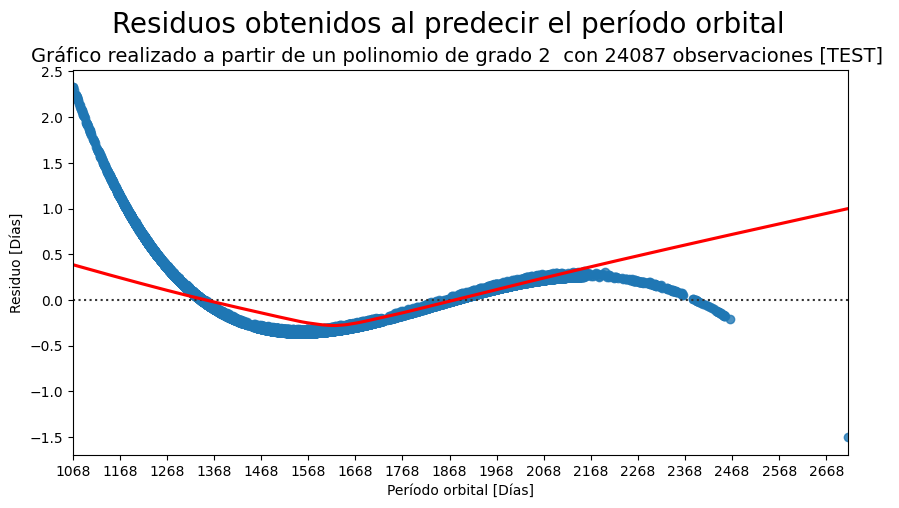

In [ ]:
plt.figure(figsize=(10,5 ), dpi=100)
plt.plot(alpha = 0.2)
# Crear un gráfico de residuos con línea de suavizado local
sns.residplot(x="per_real", y="residuos_grado_2", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de un polinomio de grado 2  con {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

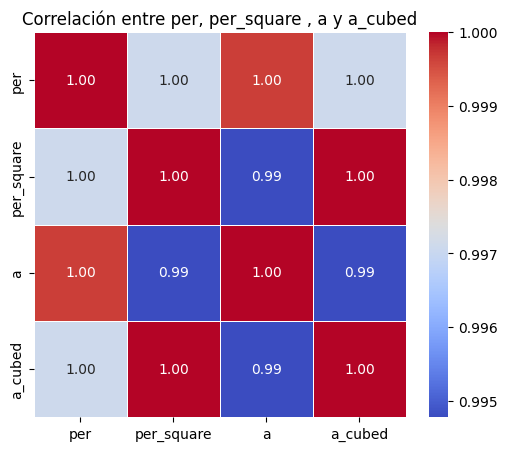

In [ ]:
# Añadir una columna adicional de "a^3" para comprobar la relación de Kepler
Asteroide_df['per_square'] = Asteroide_df['per'] ** 2
Asteroide_df['a_cubed'] = Asteroide_df['a'] ** 3

# Mapa de correlación incluyendo 'a_cubed'
corr = Asteroide_df[['per', 'per_square', 'a', 'a_cubed']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación entre per, per_square , a y a_cubed')
plt.show()

Grado: 1, Mean Squared Error: 21.05905605894581
Grado: 1.5, Mean Squared Error: 0.08196818736861175
Grado: 2, Mean Squared Error: 0.18197008618361574
Grado: 2.5, Mean Squared Error: 9.133530149075094
Grado: 3, Mean Squared Error: 0.35741314328040563


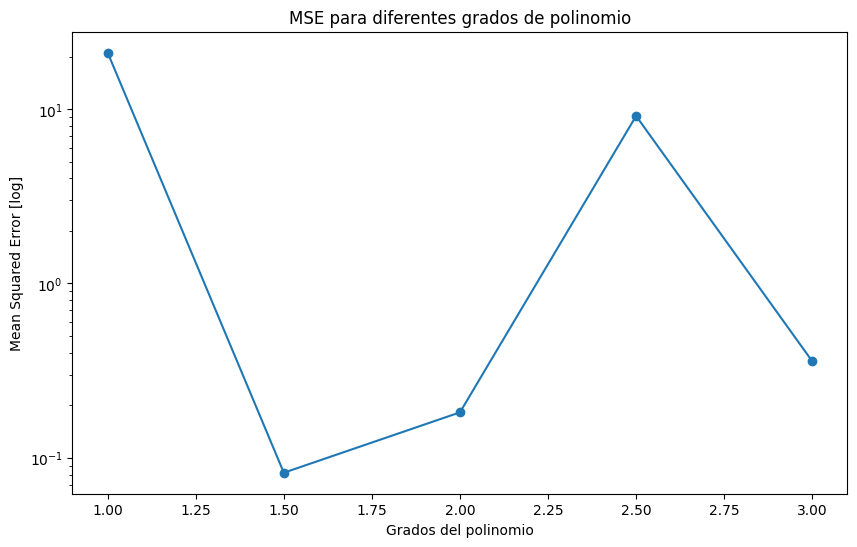

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

# Selección de características
features = Asteroide_df.drop(columns=['per'])
target = 'per'

# División de datos
X = features
y = Asteroide_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear polinomios específicos y LassoCV para cada modelo
degrees = [1, 1.5, 2, 2.5, 3]
mse_values = []
df_residuos = pd.DataFrame()
df_residuos['per_real'] = y_test.copy()

for degree in degrees:
    # Crear nuevas características polinomiales
    if degree == 1.5 or degree == 2.5:
        X_train_poly = np.power(X_train, degree)
        X_test_poly = np.power(X_test, degree)
    else:
        poly = PolynomialFeatures(degree=int(degree), include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

    # Escalado de características
    scaler = StandardScaler()
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_test_poly = scaler.transform(X_test_poly)

    # Entrenar el modelo LassoCV
    lasso = LassoCV(cv=5,max_iter=1000000, random_state=42)
    lasso.fit(X_train_poly, y_train)

    # Predicción y evaluación
    y_pred = lasso.predict(X_test_poly)
    df_residuos['residuos_grado_'+ str(degree)] = y_test.copy() - y_pred.copy()
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

    print(f'Grado: {degree}, Mean Squared Error: {mse}')

# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values, marker='o')
plt.xlabel('Grados del polinomio')
plt.ylabel('Mean Squared Error [log]')
plt.yscale('log')
plt.title('MSE para diferentes grados de polinomio')
plt.show()


NameError: name 'ticks' is not defined

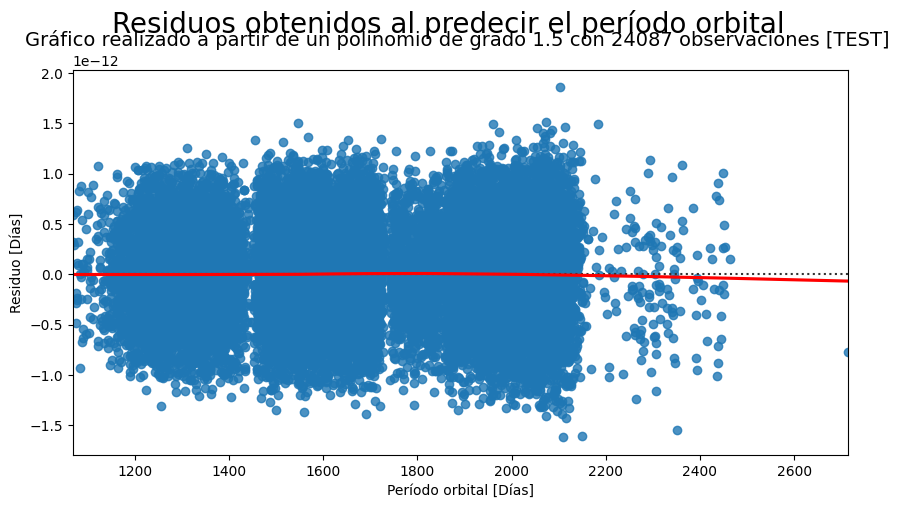

In [ ]:
plt.figure(figsize=(10,5 ), dpi=100)
plt.plot(alpha = 0.2)
# Crear un gráfico de residuos con línea de suavizado local
sns.residplot(x="per_real", y="residuos_grado_1.5", data=df_residuos, lowess=True,
              line_kws=dict(color="r"))
plt.ylabel("Residuo [Días]")
plt.xlabel("Período orbital [Días]")

plt.title(f"Gráfico realizado a partir de un polinomio de grado 1.5 con {len(X_test)} observaciones [TEST] ",fontsize=14)
plt.suptitle("Residuos obtenidos al predecir el período orbital",fontsize=20, y=1)

plt.xticks(ticks)

# Mostrar el gráfico
plt.show()

Number of features in X_train_poly: 24
Number of features in original dataset: 12
Number of coefficients: 24


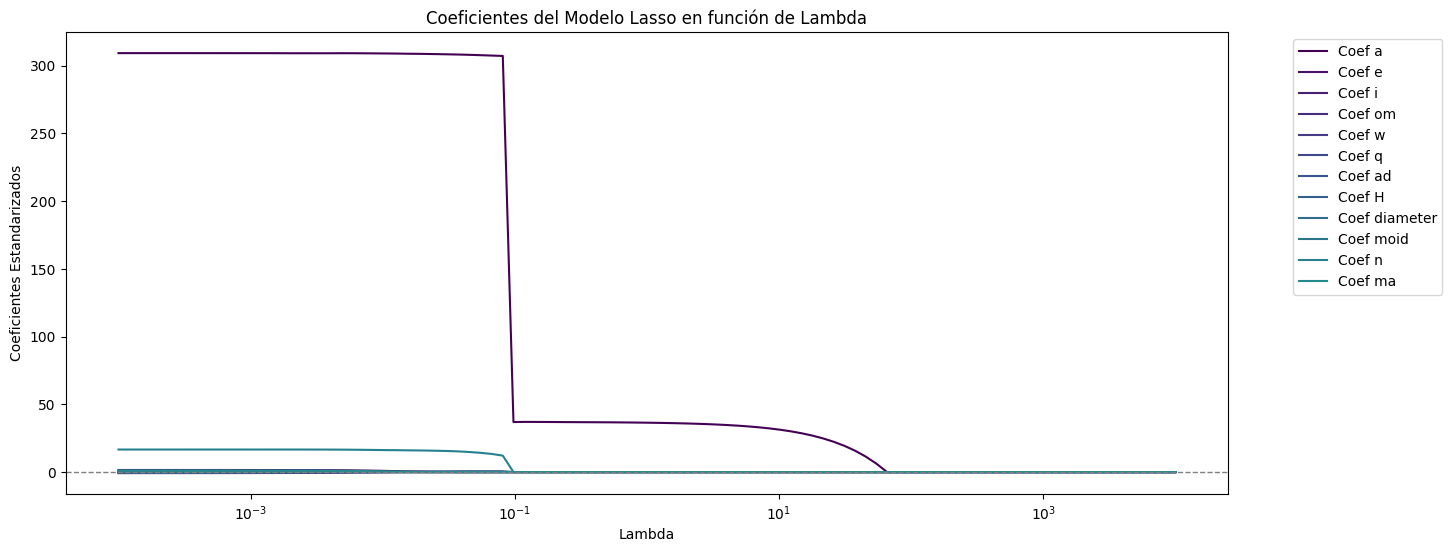

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar el mejor modelo (con el menor MSE)
optimal_degree = degrees[np.argmin(mse_values)]

if optimal_degree == 1.5:
    X_train_poly = np.concatenate([X_train, np.power(X_train, optimal_degree)], axis=1)
    X_test_poly = np.concatenate([X_test, np.power(X_test, optimal_degree)], axis=1)
else:
    poly = PolynomialFeatures(degree=int(optimal_degree), include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

# Escalado de características
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Verificar el número de características y coeficientes
print(f"Number of features in X_train_poly: {X_train_poly.shape[1]}")
print(f"Number of features in original dataset: {len(features.columns)}")

# Valores de lambda para Lasso
lambdas = np.logspace(-4, 4, 100)
coefficients = []

for l in lambdas:
    lasso = Lasso(alpha=l, max_iter=10000)
    lasso.fit(X_train_poly, y_train)
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Verificar el número de coeficientes
print(f"Number of coefficients: {coefficients.shape[1]}")

# Ajustar el bucle de visualización para el número correcto de características
plt.figure(figsize=(15, 6))
colors = plt.cm.viridis(np.linspace(0, 1, coefficients.shape[1]))
for i in range(min(coefficients.shape[1], len(features.columns))):
    plt.plot(lambdas, coefficients[:, i], label=f'Coef {features.columns[i]}', color=colors[i])
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coeficientes Estandarizados')
plt.title('Coeficientes del Modelo Lasso en función de Lambda')
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


La matriz de correlación muestra una correlación perfecta (1) entre per_square y a_cubed. Buscamos si existe una teoria que nos describa esta correlacion

La tercera ley de Kepler establece que el cuadrado del período orbital de un planeta es proporcional al cubo del semieje mayor de su órbita elíptica. En otras palabras, hay una relación entre el período orbital y el semieje mayor de la órbita. Esto explica la alta correlacion de per y ad.

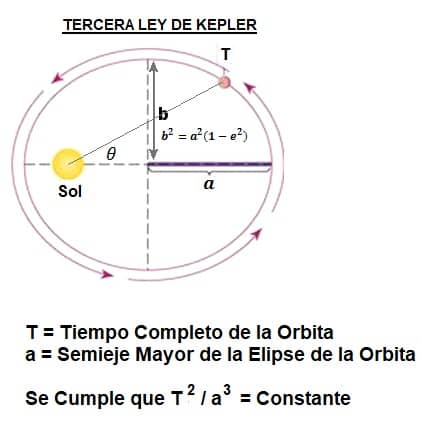
